In [2]:
!pip install razdel

In [3]:
!pip install datasets

# Подгружаем нужные нам библиотеки библиотеки

In [84]:
import pandas as pd
import json
from razdel import tokenize
from datasets import Dataset, DatasetDict


from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import numpy as np

# Предобрабатываем данные

In [85]:
data = pd.read_csv("/kaggle/input/ner-data-for-cp/ner_data_train.csv")

In [86]:
data

,video_info,entities
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"{""label"":""локация""\,""offset"":26\,""length"":6\,""..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"{""label"":""организация""\,""offset"":196\,""length""..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"{""label"":""название проекта""\,""offset"":12\,""len..."
3,<НАЗВАНИЕ:> Довоенная немецкая кирха в Калинин...,"{""label"":""не найдено""\,""offset"":162\,""length"":..."
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомоти...","{""label"":""команда""\,""offset"":13\,""length"":8\,""..."
...,...,...
6417,<НАЗВАНИЕ:> ЗАПРЕЩЕННЫЙ УДАР! Полный бой Вадим...,"{""label"":""персона""\,""offset"":41\,""length"":12\,..."
6418,<НАЗВАНИЕ:> Как создаются медали: оптические и...,"{""label"":""локация""\,""offset"":88\,""length"":10\,..."
6419,"<НАЗВАНИЕ:> Ремонт ломовоза камаз, монтаж гидр...","{""label"":""бренд""\,""offset"":28\,""length"":5\,""se..."
6420,<НАЗВАНИЕ:> Голодные игры: Баллада о змеях и п...,"{""label"":""Дата""\,""offset"":78\,""length"":4\,""seg..."


In [87]:
df = data.copy()
df['entities'] = df['entities'].apply(lambda l: l.replace('\,', ',')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: l.replace('\\\\', '\\')if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: '[' + l + ']'if isinstance(l, str) else l)
df['entities'] = df['entities'].apply(lambda l: json.loads(l)if isinstance(l, str) else l)

In [88]:
def extract_labels(item):
    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(item['video_info'])
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != 'не найдено':
                e_words = sorted({idx for idx in char2word[e['offset']:e['offset']+e['length']] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [89]:
ner_data = [extract_labels(item) for i, item in df.iterrows()]

In [90]:
ner_data[0]

{'tokens': ['<',
  'НАЗВАНИЕ',
  ':',
  '>',
  'Агент',
  '117',
  ':',
  'Из',
  'Африки',
  'с',
  'любовью',
  '—',
  'Русский',
  'тизер',
  '=',
  'трейлер',
  '(',
  '2021',
  ')',
  '<',
  'ОПИСАНИЕ',
  ':',
  '>',
  'Лучший',
  'Telegram',
  'канал',
  'о',
  'кино',
  '<',
  'LINK',
  '>',
  'Сотрудничество',
  '<',
  'LINK',
  '>',
  'Дата',
  'выхода',
  '26',
  'августа',
  '2021',
  'Оригинальное',
  'название',
  ':',
  'OSS',
  '117',
  ':',
  'Alerte',
  'rouge',
  'en',
  'Afrique',
  'noire',
  'Страна',
  ':',
  'Франция',
  'Режиссер',
  ':',
  'Николя',
  'Бедос',
  'Жанр',
  ':',
  'боевик',
  ',',
  'комедия',
  'В',
  'главных',
  'ролях',
  ':',
  'Жан',
  'Дюжарден',
  ',',
  'Пьер',
  'Нинэ',
  ',',
  'Мелоди',
  'Каста',
  ',',
  'Наташа',
  'Линдинжер',
  ',',
  'Владимир',
  'Иорданов',
  ',',
  'Фату',
  'Н',
  '’',
  'Диайе',
  ',',
  'Пол',
  'Уайт',
  'Мир',
  'изменился',
  '.',
  'Он',
  'нет',
  '.',
  'Судьба',
  'заносит',
  'легендарного',
  'Аге

In [91]:
data['tags'] = pd.DataFrame(ner_data)['tags']

In [92]:
data = data.drop(columns=['entities'])

In [93]:
data

,video_info,tags
0,<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Р...,"[O, O, O, O, O, O, O, O, B-локация, O, O, O, O..."
1,<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 V...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Челов...,"[O, O, O, O, B-название проекта, I-название пр..."
3,<НАЗВАНИЕ:> Довоенная немецкая кирха в Калинин...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомоти...","[O, O, O, O, O, B-команда, O, O, O, O, B-коман..."
...,...,...
6417,<НАЗВАНИЕ:> ЗАПРЕЩЕННЫЙ УДАР! Полный бой Вадим...,"[O, O, O, O, O, O, O, O, O, B-персона, I-персо..."
6418,<НАЗВАНИЕ:> Как создаются медали: оптические и...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6419,"<НАЗВАНИЕ:> Ремонт ломовоза камаз, монтаж гидр...","[O, O, O, O, O, O, B-бренд, O, O, O, O, O, O, ..."
6420,<НАЗВАНИЕ:> Голодные игры: Баллада о змеях и п...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [94]:
tags = []
for i in data.tags:
    tags.extend(i)
tags = np.array(sorted(set(tags), reverse=True))
tags

array(['O', 'I-серия', 'I-сезон', 'I-персона', 'I-организация',
       'I-название проекта', 'I-модель', 'I-локация', 'I-лига',
       'I-команда', 'I-видеоигра', 'I-вид спорта', 'I-бренд', 'I-Дата',
       'B-серия', 'B-сезон', 'B-персона', 'B-организация',
       'B-название проекта', 'B-модель', 'B-локация', 'B-лига',
       'B-команда', 'B-видеоигра', 'B-вид спорта', 'B-бренд', 'B-Дата'],
      dtype='<U18')

In [95]:
X = list(data['video_info'])
Y = list(data['tags'])

In [96]:
from ast import literal_eval
Y_ready = []

for sen_tags in Y:
    Y_ready.append(sen_tags)

In [97]:
print("First three sentences: \n")
print(X[:3])

First three sentences: 

['<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Русский тизер=трейлер (2021) <ОПИСАНИЕ:>Лучший Telegram канал о кино <LINK> Сотрудничество <LINK> Дата выхода 26 августа 2021 Оригинальное название: OSS 117: Alerte rouge en Afrique noire Страна: Франция Режиссер: Николя Бедос Жанр: боевик, комедия В главных ролях: Жан Дюжарден, Пьер Нинэ, Мелоди Каста, Наташа Линдинжер, Владимир Иорданов, Фату Н’Диайе, Пол Уайт Мир изменился. Он нет. Судьба заносит легендарного Агента 117 в Африку, где горячее пустыни только женщины. Вооруженный неиссякаемой уверенностью в себе и убийственной харизмой, он может справиться со всеми врагами, кроме самого себя. По вопросам авторского права, пожалуйста, свяжитесь с нами по адресу: <AT>', '<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 VK56 VK56DE VK56=DE Коленный Вал Infiniti QX56= 5.6 стандартный <ОПИСАНИЕ:><LINK> kolenval infiniti iks.html Коленвал Инфинити Ку икс 56\u200b Коленный Вал Infiniti QX56\u200b Модель Двигателя: VK56, VK56D

In [98]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [99]:
print("Number of examples: {}".format(len(X)))

Number of examples: 6422


In [100]:
max([len(i) for i in X])

999

In [101]:
max([len(i) for i in Y])

367

In [102]:
maxlen = 367
max_words = 999

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [103]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 80523 unique tokens.


In [104]:
word2id = word_index

id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [105]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [106]:
X_preprocessed[0]

array([  5,  16,   7,  20, 126,  60,  52,   6, 445,  96,  10,  14,  91,
         1, 597,   1, 101,  97, 398, 567,  52, 301,   5, 194, 189, 193,
       420, 325,   2, 598, 389, 308, 157,  57, 344,   2,  95,  72,   2,
       362,   3,  57, 203,  85, 768, 209,   8, 276, 494, 715,   7, 330,
         8,  27,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [107]:
X_preprocessed[2247]

array([  5, 154,  21,   3,   4,   6,   3, 492, 413, 340,   2,  15,  71,
        71, 808,   3, 131, 288,  40, 391,   2, 182,  25,  64, 426,   4,
        18,  24, 148, 370, 340,  78,   1,  78,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [108]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i

In [109]:
tags2id

{'O': 0,
 'I-серия': 1,
 'I-сезон': 2,
 'I-персона': 3,
 'I-организация': 4,
 'I-название проекта': 5,
 'I-модель': 6,
 'I-локация': 7,
 'I-лига': 8,
 'I-команда': 9,
 'I-видеоигра': 10,
 'I-вид спорта': 11,
 'I-бренд': 12,
 'I-Дата': 13,
 'B-серия': 14,
 'B-сезон': 15,
 'B-персона': 16,
 'B-организация': 17,
 'B-название проекта': 18,
 'B-модель': 19,
 'B-локация': 20,
 'B-лига': 21,
 'B-команда': 22,
 'B-видеоигра': 23,
 'B-вид спорта': 24,
 'B-бренд': 25,
 'B-Дата': 26}

In [110]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key

In [111]:
id2tag

{0: 'O',
 1: 'I-серия',
 2: 'I-сезон',
 3: 'I-персона',
 4: 'I-организация',
 5: 'I-название проекта',
 6: 'I-модель',
 7: 'I-локация',
 8: 'I-лига',
 9: 'I-команда',
 10: 'I-видеоигра',
 11: 'I-вид спорта',
 12: 'I-бренд',
 13: 'I-Дата',
 14: 'B-серия',
 15: 'B-сезон',
 16: 'B-персона',
 17: 'B-организация',
 18: 'B-название проекта',
 19: 'B-модель',
 20: 'B-локация',
 21: 'B-лига',
 22: 'B-команда',
 23: 'B-видеоигра',
 24: 'B-вид спорта',
 25: 'B-бренд',
 26: 'B-Дата'}

In [112]:
def preprocess_tags(tags2id, Y_ready):
    
    Y_preprocessed = []
    maxlen = 367
    for y in Y_ready:
        Y_place_holder = []
        
        for tag in y:
            Y_place_holder.append(tags2id[tag])
        
        len_new_tag_list = len(Y_place_holder)
        num_O_to_add = maxlen - len_new_tag_list
        
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [113]:
Y_preprocessed = preprocess_tags(tags2id, Y_ready)

In [114]:
print(Y_preprocessed[0])

[0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 13, 13, 0, 0, 0, 18, 5, 5, 5, 5, 5, 5, 5, 0, 0, 20, 0, 0, 16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 3, 0, 16, 3, 0, 16, 3, 0, 16, 3, 0, 16, 3, 0, 16, 3, 3, 3, 0, 16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [115]:
print(Y_ready[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-локация', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Дата', 'I-Дата', 'I-Дата', 'O', 'O', 'O', 'B-название проекта', 'I-название проекта', 'I-название проекта', 'I-название проекта', 'I-название проекта', 'I-название проекта', 'I-название проекта', 'I-название проекта', 'O', 'O', 'B-локация', 'O', 'O', 'B-персона', 'I-персона', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-персона', 'I-персона', 'O', 'B-персона', 'I-персона', 'O', 'B-персона', 'I-персона', 'O', 'B-персона', 'I-персона', 'O', 'B-персона', 'I-персона', 'O', 'B-персона', 'I-персона', 'I-персона', 'I-персона', 'O', 'B-персона', 'I-персона', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-локация', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [116]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [117]:
# 70% of the datat will be used for training 
training_samples = 0.8
# 15% of the datat will be used for validation 
validation_samples = 0.15

indices = np.arange(len(Y_preprocessed))

np.random.seed(seed=555)
np.random.shuffle(indices)

X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

# Делим на выборки и создаём модель

In [118]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X_preprocessed, Y_preprocessed,
                                                  test_size=0.15,
                                                  random_state=42)

In [119]:
trainX

array([[  5, 277,  12, ...,   0,   0,   0],
       [  5, 271,  42, ...,   0,   0,   0],
       [  5, 378,  14, ...,   0,   0,   0],
       ...,
       [  5, 845,   3, ...,   0,   0,   0],
       [  5, 343, 343, ...,   0,   0,   0],
       [  5, 651,   4, ...,   0,   0,   0]], dtype=int32)

In [120]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
val_dataset = tf.data.Dataset.from_tensor_slices((testX, testY))

In [121]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 64

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [122]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
# from tensorflow_addons.layers import CRF
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
# from tensorflow_addons.optimizers import AdamW

from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.layers import LSTM, Embedding, Dense

with tf.device('/GPU:0'):
    embedding_dim = 128
    maxlen = 367
    max_words = 999
    num_tags = len(tags)

    model = tf.keras.models.Sequential([
        Embedding(max_words, embedding_dim, input_length=maxlen, trainable=True),
        SpatialDropout1D(0.1),
        Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)),
        Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)),
        TimeDistributed(Dense(num_tags, activation='softmax'))
    ])

#     input_ = Input(shape=(maxlen,))
#     embeddings = Embedding(max_words, embedding_dim, input_length=maxlen, trainable=True)(input_)
#     output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
#     output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
    
#     output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

#     dense_out = TimeDistributed(Dense(num_tags, activation="softmax"))(output_sequences)

#     crf = CRF(num_tags)
#     predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)
    
#     model = Model(input_, potentials)

In [123]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 367, 128)          127872    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 367, 128)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_30 (Bidirecti  (None, 367, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 367, 256)         394240    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 367, 27)          6939      
 stributed)                                           

In [124]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

with tf.device('/GPU:0'):
    checkpointer = ModelCheckpoint(filepath='ner_model.h5', verbose=1, save_best_only=True)
    
    opt = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)

#     model.compile(
#         optimizer=AdamW(weight_decay=0.001),
#         loss=SigmoidFocalCrossEntropy())

In [125]:
with tf.device('/GPU:0'):
    H = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=50,
                    shuffle=True,
                    callbacks=[checkpointer])

Epoch 1/50
86/86 [==============================] - ETA: 0s - loss: 0.3899
Epoch 1: val_loss improved from inf to 0.20639, saving model to ner_model.h5
86/86 [==============================] - 377s 4s/step - loss: 0.3899 - val_loss: 0.2064
Epoch 2/50
86/86 [==============================] - ETA: 0s - loss: 0.1958
Epoch 2: val_loss improved from 0.20639 to 0.20147, saving model to ner_model.h5
86/86 [==============================] - 362s 4s/step - loss: 0.1958 - val_loss: 0.2015
Epoch 3/50
86/86 [==============================] - ETA: 0s - loss: 0.1903
Epoch 3: val_loss improved from 0.20147 to 0.19425, saving model to ner_model.h5
86/86 [==============================] - 359s 4s/step - loss: 0.1903 - val_loss: 0.1943
Epoch 4/50
86/86 [==============================] - ETA: 0s - loss: 0.1860
Epoch 4: val_loss improved from 0.19425 to 0.19171, saving model to ner_model.h5
86/86 [==============================] - 357s 4s/step - loss: 0.1860 - val_loss: 0.1917
Epoch 5/50
86/86 [==========

In [126]:
model.evaluate(val_dataset)

16/16 [==============================] - 5s 325ms/step - loss: 0.1847


0.18466675281524658

Text(0.5, 1.0, 'Loss')

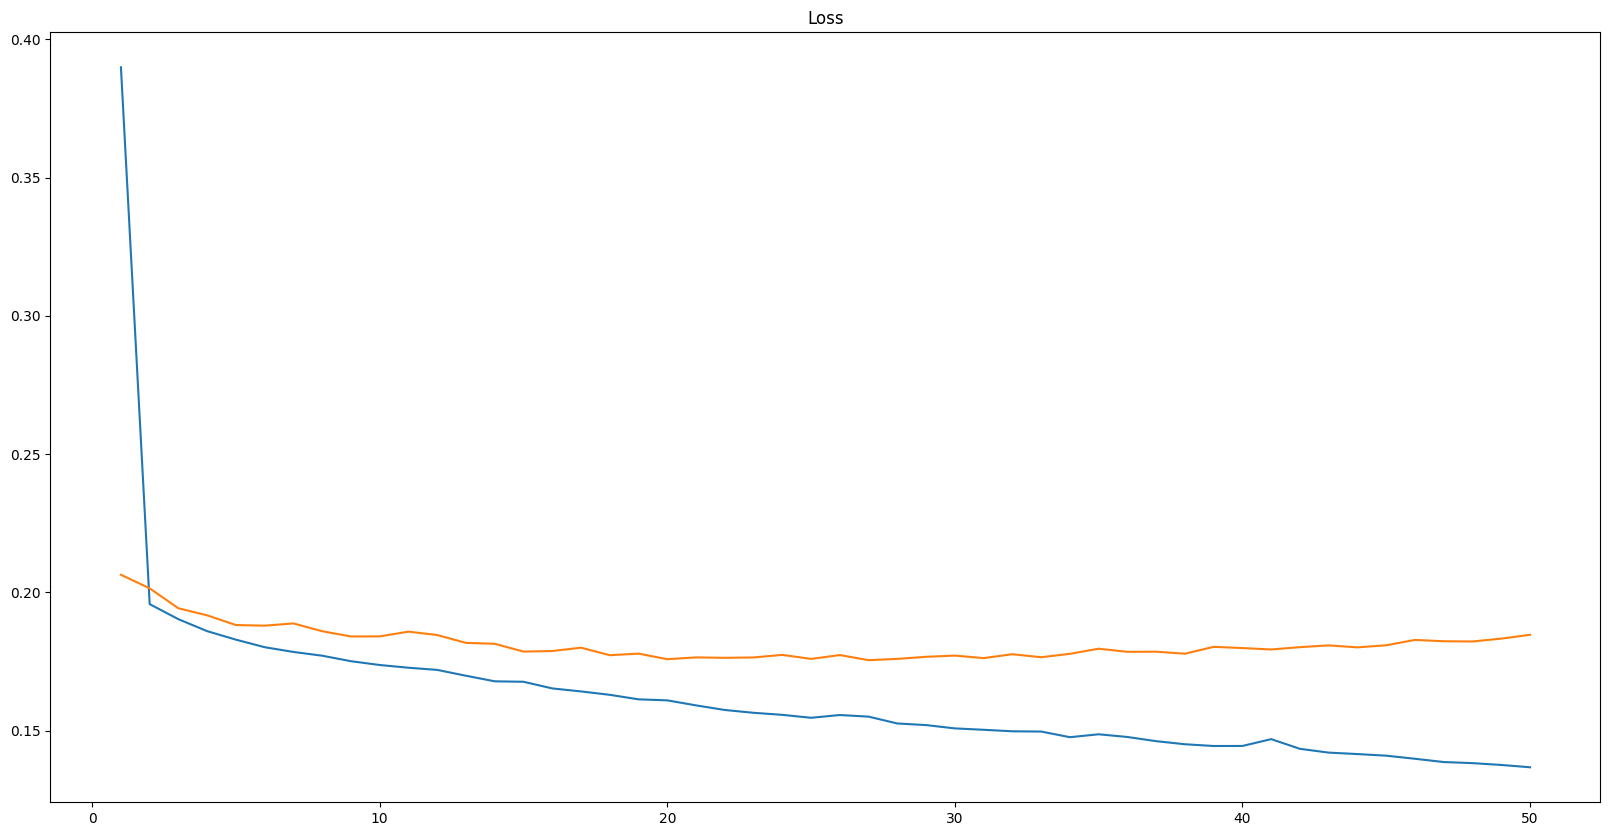

In [127]:
import matplotlib
import matplotlib.pyplot as plt

val_loss = H.history['loss']
plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, len(val_loss) + 1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, len(val_loss) + 1), H.history["val_loss"], label="vall_loss")
plt.title("Loss")

### смотрим на предсказания

In [187]:
def make_prediction(model, preprocessed_sentence, id2word, id2tag):
    
    preprocessed_sentence = preprocessed_sentence.reshape((1, 367))
    
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sententce = ' '.join(word_list)
    
    len_orginal_sententce = len(word_list)
    
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)
    print(prediction)
    
    prediction = list(prediction)
    
    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    
    return orginal_sententce, pred_tag_list

In [188]:
i = 5

In [189]:
modelH5 = tf.keras.models.load_model("/kaggle/working/ner_model.h5")
print("Model loaded")

Model loaded


In [190]:
testX[i]

array([  5, 658,  14,   3,   6,   4,  14,   2, 690, 106,   2,  69,   2,
       475,  17, 394,   2,   8,   2,  70, 151, 285,   2, 205,  46, 810,
       935,  15, 267, 962,  43, 217,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [191]:
orginal_sententce,  pred_tag_list = make_prediction(model=modelH5,
                                                    preprocessed_sentence=testX[i],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

1/1 [==============================] - 1s 1s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [192]:
print(orginal_sententce)

название информация о и описание на о в сразу же в сайт в минут 1 е в по в то время там в этой до 80 которое для детей необходимо его просто


In [193]:
print(testY[i])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [194]:
print(pred_tag_list)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',